### Logging imports and setup

In [1]:
LOGS_FOLDER = "logs"

import logging
from time import sleep, strftime, localtime, time

from pathlib import Path
Path(LOGS_FOLDER).mkdir(parents=True, exist_ok=True)

def timestamp():
    return strftime("%Y_%m_%d_%H_%M_%S", localtime())

logging.basicConfig(filename=f'{LOGS_FOLDER}/log_{timestamp()}.txt',filemode='a',format='%(asctime)s - %(name)s - %(levelname)s - %(funcName)s() - %(message)s',level=logging.INFO)

def print_n_log(string):
    print(string)
    logging.info(string)


### Imports

In [2]:
from torch import nn
from torch.nn import functional as F
from torch import optim
from torchvision import datasets

from matplotlib import pyplot as plt

try:
    from tqdm import tqdm
except ImportError:
    tqdm = lambda x: x

import torch
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.get_device_name(torch.cuda.current_device())

'NVIDIA GeForce RTX 3060 Laptop GPU'

### Loading data

In [3]:
PATH_DATA = '../../../data'

noisy_imgs_1, noisy_imgs_2 = torch.load(PATH_DATA + '/train_data.pkl')

noisy_imgs, clean_imgs = torch.load(PATH_DATA + '/val_data.pkl')

In [10]:
noisy_imgs_1.shape, noisy_imgs_2.shape

(torch.Size([50000, 3, 32, 32]), torch.Size([50000, 3, 32, 32]))

In [11]:
noisy_imgs.shape, clean_imgs.shape

(torch.Size([1000, 3, 32, 32]), torch.Size([1000, 3, 32, 32]))

In [12]:
train_input,train_target=noisy_imgs_1.float(),noisy_imgs_2.float()
test_input,test_target=noisy_imgs.float(),clean_imgs.float()/255.0

In [13]:
test_input=test_input.to(device)
test_target=test_target.to(device)
train_input=train_input.to(device)
train_target=train_target.to(device)
None

### Taking a small sample of data for fast training/expermientation. Comment if not needed

In [14]:
# def subsample(tensor):
#     n_samples = tensor.size(dim=0)
#     return tensor[0:n_samples // 10]

# train_input = subsample(train_input)
# train_target = subsample(train_target)

# train_input.shape, train_target.shape

### Basic data exploration

In [15]:
def show_image(image_tensor):
    plt.imshow(image_tensor.cpu().permute(1, 2, 0))
    plt.show()


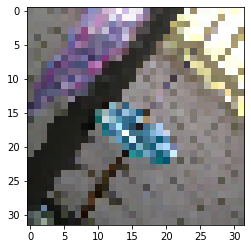

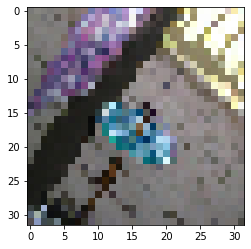

In [21]:
show_image(train_input[0]/255.0)
show_image(train_target[0]/255.0)

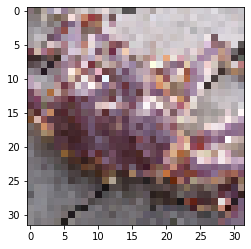

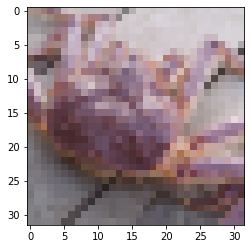

In [22]:
show_image(test_input[0]/255.0)
show_image(test_target[0])

### Model, optimizer and loss function definitions

In [86]:
# michaelsmac, 1/10 training samples, 10 Epochs, 11s, psnr=23.74
model1 = nn.Sequential(
    nn.Linear(32, 128),
    nn.Linear(128, 32)
)

# tikonGPU, all training samples, 50 Epochs, 100 batch_size, 45 sec, psnr=24.46
model_tikhon=nn.Sequential(
    nn.Linear(32, 128),
    nn.ReLU(),
    nn.Conv2d(3,3,2),
    nn.ReLU(),
    nn.ConvTranspose2d(3,3,2),
    nn.ReLU(),    
    nn.Linear(128, 32)
)

# michaelsmac, 1/10 training samples, 10 Epochs, 36s, psnr=24.75
model2 = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=3),
    nn.ReLU(),
    nn.ConvTranspose2d(32, 3, kernel_size=3, padding=3),
    nn.ReLU(),
)

# michaelsmac, 1/10 training samples, 10 Epochs, 34s, psnr=24.72
model2v1 = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=3, bias=False),
    nn.ReLU(),
    nn.ConvTranspose2d(32, 3, kernel_size=3, padding=3, bias=False),
    nn.ReLU(),
)

# michaelsmac, 1/10 training samples, 10 Epochs, 34s, psnr=24.73
model2v2 = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=3, bias=False),
    nn.LeakyReLU(),
    nn.ConvTranspose2d(32, 3, kernel_size=3, padding=3, bias=False),
    nn.ReLU(),
)

# michaelsmac, 1/10 training samples, 10 Epochs, 41s, psnr=23.56
model3 = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=3),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.ConvTranspose2d(32, 3, kernel_size=3, padding=3),
    nn.ReLU(),
)

# michaelsmac, 1/10 training samples, 10 Epochs, 1m, psnr=24.80
# michaelsmac, all training samples, 10 Epochs, 1m, psnr=24.80
# tikhonGPU, all training samples, 50 Epochs, 100 batch_size, psnr=25.17, time~50 sec
# tikhonGPU, all training samples, 50 Epochs, 20 batch_size, psnr=25.18, time~2 min

model4 = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, padding=3),
    nn.ReLU(),
    nn.ConvTranspose2d(64, 3, kernel_size=3, padding=3),
    nn.ReLU(),
)

# michaelsmac, 1/10 training samples, 10 Epochs, 1.5m, psnr=24.73
model5 = nn.Sequential(
    nn.Conv2d(3, 128, kernel_size=3, padding=3),
    nn.ReLU(),
    nn.ConvTranspose2d(128, 3, kernel_size=3, padding=3),
    nn.ReLU(),
)

# michaelsmac, 1/10 training samples, 10 Epochs, 13m, psnr=25.01
model6 = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=3),
    nn.ReLU(),
    nn.Conv2d(32, 128, kernel_size=3, padding=3),
    nn.ReLU(),
    nn.ConvTranspose2d(128, 32, kernel_size=3, padding=3),
    nn.ReLU(),
    nn.ConvTranspose2d(32, 3, kernel_size=3, padding=3),
    nn.ReLU(),
)

# michaelsmac, 1/10 training samples, 10 Epochs, 5m, psnr=24.31
model_polling1 = nn.Sequential(
    # 1st layer
    nn.Conv2d(3, 32, kernel_size=3, padding=3, bias=False),
    nn.ReLU(),

    # Max pool 2x2
    nn.MaxPool2d(2, 2), # check ceil_mode=False

    #3nd layer
    nn.Conv2d(32, 128, kernel_size=3, padding=3, bias=False),
    nn.ReLU(),

    #4th layer
    nn.ConvTranspose2d(128, 32, kernel_size=3, padding=3, bias=False),
    nn.ReLU(),

    # Up-conv 2x2
    nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2, bias=False),

    #6th layer
    nn.ConvTranspose2d(32, 3, kernel_size=3, padding=3, bias=False),
    nn.ReLU(),
)

# tikonGPU, all training samples, 50 Epochs, 100 batch_size, 5 min, psnr=25.57 (25.5 after 30 epochs)
model_cezary = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 48, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(48, 48, 3, padding=1),
            nn.ReLU(inplace=1),
            nn.Conv2d(48, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, 3, stride=1, padding=1),
            nn.LeakyReLU(-0.1)
        )

In [87]:
# model = model1; print_n_log(f'=== Using model1 ===')
# model = model2; print_n_log(f'=== Using model2 ===')
# model = model2v1; print_n_log(f'=== Using model2v1 ===')
# model = model2v2; print_n_log(f'=== Using model2v2 ===')
# model = model3; print_n_log(f'=== Using model3 ===')
# model = model4; print_n_log(f'=== Using model4 ===')
# model = model5; print_n_log(f'=== Using model5 ===')
# model = model_polling1; print_n_log(f'=== Using model_polling1 ===')
#model = model_tikhon; print_n_log(f'=== Using model_tikhon ===')
model = model_cezary; print_n_log(f'=== Using model_cezary ===')



model.to(device)

=== Using model_cezary ===


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU(inplace=True)
  (6): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): LeakyReLU(negative_slope=-0.1)
)

In [88]:
optimizer=torch.optim.Adam(model.parameters(),lr=1e-3)
# optimizer=torch.optim.SGD(model.parameters(), lr=1e-3)
loss_fn=nn.MSELoss().to(device)

In [89]:
def psnr(denoised,ground_truth):
    mse=torch.mean((denoised-ground_truth)**2)
    return  - 10 * torch.log10(((denoised-ground_truth) ** 2).mean((1,2,3))).mean()

### Model training and testing

In [90]:
batch_size = 100
nb_epochs = 30

for e in range(nb_epochs):
    print_n_log(f'Epoch -> {e}')
    losses=[]
    start_time = time.time()
    # Run optimization alg for all batches of data
    for b in range(0,train_input.size(0),batch_size):

        # Compute prediction error on batch
        pred = model(train_input.narrow(0, b, batch_size))
        loss = loss_fn(pred, train_target.narrow(0, b, batch_size))
        losses.append(loss)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    current_time = time.time()
    elapsed_time = current_time - start_time
    print_n_log('Time----->{} seconds'.format(elapsed_time))
    print_n_log(f'\tloss={sum(losses)/(train_input.size(0)/batch_size)}')

    # Print test psnr
    #with torch.no_grad():
    #    print_n_log(f'\Train psnr={psnr(model(train_input), train_target)}')

Epoch -> 0
Time----->9.78984022140503 seconds
	loss=1438.8406982421875
Epoch -> 1
Time----->9.651958227157593 seconds
	loss=968.994140625
Epoch -> 2
Time----->9.684547901153564 seconds
	loss=961.0821533203125
Epoch -> 3
Time----->9.698793411254883 seconds
	loss=957.161376953125
Epoch -> 4
Time----->9.716855764389038 seconds
	loss=954.337646484375
Epoch -> 5
Time----->9.725934505462646 seconds
	loss=952.6126708984375
Epoch -> 6
Time----->9.744089365005493 seconds
	loss=951.227783203125
Epoch -> 7
Time----->9.75639533996582 seconds
	loss=949.3511962890625
Epoch -> 8
Time----->9.76822280883789 seconds
	loss=948.7312622070312
Epoch -> 9
Time----->9.78120493888855 seconds
	loss=947.384765625
Epoch -> 10
Time----->9.784234285354614 seconds
	loss=946.386962890625
Epoch -> 11
Time----->9.8000807762146 seconds
	loss=945.3446655273438
Epoch -> 12
Time----->9.811388731002808 seconds
	loss=944.4953002929688
Epoch -> 13
Time----->9.81256628036499 seconds
	loss=943.6682739257812
Epoch -> 14
Time----

In [37]:
models_losses=[]
for m in [model1,model_tikhon,model2,model2v1,model2v2,model3,model3,model4,model5,model6,model_polling1,model_cezary]:
    s=f'=== Using '+[name for name in globals() if globals()[name] is m][0]+' ==='
    model = m; print_n_log(s)
    model.to(device)
    optimizer=torch.optim.Adam(model.parameters(),lr=1e-3)
    loss_fn=nn.MSELoss().to(device)
    
    batch_size = 100
    nb_epochs = 50

    for e in range(nb_epochs):
        if e%10==9 or e==0:
            print_n_log(f'Epoch -> {e+1}')
        losses=[]
        start_time = time.time()
        # Run optimization alg for all batches of data
        for b in range(0,train_input.size(0),batch_size):

            # Compute prediction error on batch
            pred = model(train_input.narrow(0, b, batch_size))
            loss = loss_fn(pred, train_target.narrow(0, b, batch_size))
            losses.append(loss)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        current_time = time.time()
        elapsed_time = current_time - start_time
        if e%10==9 or e==0:
            print_n_log('Time----->{} seconds'.format(elapsed_time))
            print_n_log(f'\tloss={sum(losses)/(train_input.size(0)/batch_size)}')
    models_losses.append(sum(losses)/(train_input.size(0)/batch_size))

=== Using model1 ===
Epoch -> 1
Time----->0.3979990482330322 seconds
	loss=0.01610037498176098
Epoch -> 10
Time----->0.3990001678466797 seconds
	loss=0.01609388180077076
Epoch -> 20
Time----->0.40740370750427246 seconds
	loss=0.01609228365123272
Epoch -> 30
Time----->0.4060018062591553 seconds
	loss=0.01609058491885662
Epoch -> 40
Time----->0.4100019931793213 seconds
	loss=0.01608879305422306
Epoch -> 50
Time----->0.41300129890441895 seconds
	loss=0.016087055206298828
=== Using model_tikhon ===
Epoch -> 1
Time----->0.8669548034667969 seconds
	loss=0.015084509737789631
Epoch -> 10
Time----->0.9312677383422852 seconds
	loss=0.015061607584357262
Epoch -> 20
Time----->0.9106743335723877 seconds
	loss=0.015054467134177685
Epoch -> 30
Time----->0.9006705284118652 seconds
	loss=0.015049855224788189
Epoch -> 40
Time----->0.9334206581115723 seconds
	loss=0.015046649612486362
Epoch -> 50
Time----->0.9245853424072266 seconds
	loss=0.015044057741761208
=== Using model2 ===
Epoch -> 1
Time----->0.5

In [40]:
models=[model1,model_tikhon,model2,model2v1,model2v2,model3,model3,model4,model5,model6,model_polling1,model_cezary]
print('The best model we have is: ')
print(models[models_losses.index(min(models_losses))])

The best model we have is: 
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU(inplace=True)
  (6): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): LeakyReLU(negative_slope=0.1)
)


In [91]:
torch.save(model_cezary,'bestmodel.pth')

In [9]:
model=torch.load('bestmodel.pth')

In [92]:
print('Validation result is {}'.format(psnr(model_cezary(test_input)/255.0,test_target)))

Validation result is 25.468780517578125
